# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!git clone https://github.com/oristides/deep-learning.git

Cloning into 'deep-learning'...
remote: Counting objects: 1443, done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 1443 (delta 0), reused 0 (delta 0), pack-reused 1438
Receiving objects: 100% (1443/1443), 47.79 MiB | 21.55 MiB/s, done.
Resolving deltas: 100% (605/605), done.


In [2]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 4.9MB/s 


In [0]:
import os
os.chdir("deep-learning/face_generation/")

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:13<00:00, 4.45kFile/s]

Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

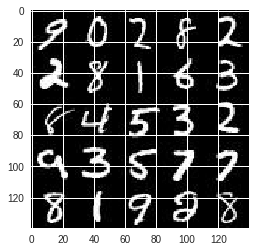

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'))

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

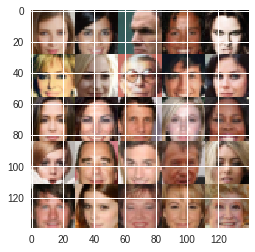

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [54]:
def discriminator(images, reuse=False, alpha= 0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 32, 5, 2,'same', use_bias=True, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 64, 5, 2,'same', use_bias=True, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x = tf.layers.batch_normalization(x, training=True)
        x =  tf.layers.dropout(x, 0.05)
        x = tf.maximum(alpha * x, x)
        
        x = tf.layers.conv2d(x, 128, 5, 2,'same', use_bias=True, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x = tf.layers.batch_normalization(x, training=True)
        x =  tf.layers.dropout(x, 0.05)
        x = tf.maximum(alpha * x, x)

        x = tf.reshape(x, (-1, 4*4*128))
        
        logits = tf.layers.dense(x, 1, activation=None)
        logits=tf.layers.dropout(logits, 0.2)
        output = tf.sigmoid(logits)
        
    return output, logits



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [74]:
def generator(z, out_channel_dim, is_train=True, alpha=0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
     alpha=0.1
    :return: The tensor output of the generator
    
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 3*3*512, use_bias=True, activation=None)
        x = tf.reshape(x, (-1, 3, 3, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.layers.dropout(x, 0.05)
        x = tf.maximum(alpha * x, x)
        
        # 3x3x256
        
        x = tf.layers.conv2d_transpose(x, 256, 5, 2,'same', use_bias=True, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x = tf.layers.batch_normalization(x, training=is_train)
        x =  tf.layers.dropout(x, 0.05)
        x = tf.maximum(alpha * x, x)
        # 6x6x 128
        
        x = tf.layers.conv2d_transpose(x, 128, 5, 2,'same', use_bias=True, activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)
        # 14x14x64
        
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 6, 2,'valid', activation=None, kernel_initializer=tf.random_normal_initializer(stddev=0.02))
        out = tf.tanh(x)
        # 28x28xout_channel_dim
        
    return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [75]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [76]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [v for v in t_vars if v.name.startswith('discriminator')]
    g_vars = [v for v in t_vars if v.name.startswith('generator')]
    

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [0]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode ):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [0]:
import time

In [0]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    init_time=time.time()
    samples, losses = [], []
    
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
   
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    b_size=batch_size
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
              steps += 1
              batch_images = np.clip(batch_images*2, -1,1)
                
              # Sample random noise for G
              batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
             
              # Run optimizers, 
              _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
              _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

              if steps % 60 == 0:
                  # At the end of each epoch, get the losses and print them out
                  train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                  train_loss_g = g_loss.eval({input_z: batch_z})
                  

                  print("Epoch {}/{}...".format(epoch_i+1, epochs),
                        "Batches {}/{}...".format(int(b_size*steps/(epoch_i+1)), data_shape[0]),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g),
                         "Time_mins: {:.0f}".format((time.time()-init_time)/60))
                  # Save losses to view after training
              
              if steps % 600 == 0:
                show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
              if int(b_size*steps/(epoch_i+1))==data_shape[0]-1: #last print
                show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
           

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batches 3840/60000... Discriminator Loss: 1.0783... Generator Loss: 0.8088 Time_mins: 0
Epoch 1/2... Batches 7680/60000... Discriminator Loss: 0.7516... Generator Loss: 1.5374 Time_mins: 0
Epoch 1/2... Batches 11520/60000... Discriminator Loss: 1.1238... Generator Loss: 0.6727 Time_mins: 0
Epoch 1/2... Batches 15360/60000... Discriminator Loss: 1.0510... Generator Loss: 1.1910 Time_mins: 0
Epoch 1/2... Batches 19200/60000... Discriminator Loss: 1.0811... Generator Loss: 0.7275 Time_mins: 1
Epoch 1/2... Batches 23040/60000... Discriminator Loss: 1.0113... Generator Loss: 1.3840 Time_mins: 1
Epoch 1/2... Batches 26880/60000... Discriminator Loss: 0.9131... Generator Loss: 1.3013 Time_mins: 1
Epoch 1/2... Batches 30720/60000... Discriminator Loss: 1.0007... Generator Loss: 1.0642 Time_mins: 1
Epoch 1/2... Batches 34560/60000... Discriminator Loss: 0.8987... Generator Loss: 0.7839 Time_mins: 1
Epoch 1/2... Batches 38400/60000... Discriminator Loss: 1.1178... Generator Loss: 0.

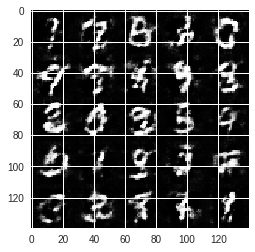

Epoch 1/2... Batches 42240/60000... Discriminator Loss: 0.9140... Generator Loss: 1.0716 Time_mins: 1
Epoch 1/2... Batches 46080/60000... Discriminator Loss: 0.8501... Generator Loss: 0.8680 Time_mins: 1
Epoch 1/2... Batches 49920/60000... Discriminator Loss: 0.9313... Generator Loss: 1.2961 Time_mins: 1
Epoch 1/2... Batches 53760/60000... Discriminator Loss: 1.0048... Generator Loss: 1.5165 Time_mins: 2
Epoch 1/2... Batches 57600/60000... Discriminator Loss: 1.1228... Generator Loss: 1.4404 Time_mins: 2
Epoch 2/2... Batches 30720/60000... Discriminator Loss: 1.1510... Generator Loss: 0.5224 Time_mins: 2
Epoch 2/2... Batches 32640/60000... Discriminator Loss: 0.9305... Generator Loss: 1.1045 Time_mins: 2
Epoch 2/2... Batches 34560/60000... Discriminator Loss: 0.9514... Generator Loss: 1.3804 Time_mins: 2
Epoch 2/2... Batches 36480/60000... Discriminator Loss: 1.1974... Generator Loss: 0.5049 Time_mins: 2
Epoch 2/2... Batches 38400/60000... Discriminator Loss: 0.9837... Generator Loss: 

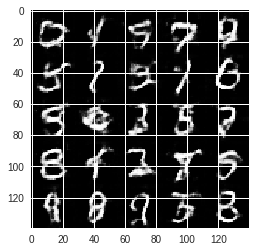

Epoch 2/2... Batches 40320/60000... Discriminator Loss: 1.1343... Generator Loss: 0.5240 Time_mins: 2
Epoch 2/2... Batches 42240/60000... Discriminator Loss: 1.0065... Generator Loss: 0.6530 Time_mins: 2
Epoch 2/2... Batches 44160/60000... Discriminator Loss: 1.1601... Generator Loss: 0.5163 Time_mins: 2
Epoch 2/2... Batches 46080/60000... Discriminator Loss: 1.1655... Generator Loss: 0.4684 Time_mins: 3
Epoch 2/2... Batches 48000/60000... Discriminator Loss: 0.9686... Generator Loss: 0.7627 Time_mins: 3
Epoch 2/2... Batches 49920/60000... Discriminator Loss: 1.0405... Generator Loss: 0.6279 Time_mins: 3
Epoch 2/2... Batches 51840/60000... Discriminator Loss: 1.5861... Generator Loss: 0.2828 Time_mins: 3
Epoch 2/2... Batches 53760/60000... Discriminator Loss: 0.7817... Generator Loss: 0.9426 Time_mins: 3
Epoch 2/2... Batches 55680/60000... Discriminator Loss: 0.9870... Generator Loss: 0.7125 Time_mins: 3
Epoch 2/2... Batches 57600/60000... Discriminator Loss: 0.7494... Generator Loss: 

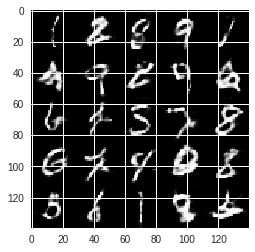

Epoch 2/2... Batches 59520/60000... Discriminator Loss: 0.9769... Generator Loss: 0.6319 Time_mins: 3


In [83]:
batch_size = 64
z_dim = 100
learning_rate = 0.00015
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Batches 1920/202599... Discriminator Loss: 0.8410... Generator Loss: 1.1674 Time_mins: 0
Epoch 1/2... Batches 3840/202599... Discriminator Loss: 0.6331... Generator Loss: 1.5462 Time_mins: 0
Epoch 1/2... Batches 5760/202599... Discriminator Loss: 0.8205... Generator Loss: 1.1257 Time_mins: 0
Epoch 1/2... Batches 7680/202599... Discriminator Loss: 1.3724... Generator Loss: 0.5096 Time_mins: 0
Epoch 1/2... Batches 9600/202599... Discriminator Loss: 1.0907... Generator Loss: 0.6978 Time_mins: 1
Epoch 1/2... Batches 11520/202599... Discriminator Loss: 0.9785... Generator Loss: 0.9628 Time_mins: 1
Epoch 1/2... Batches 13440/202599... Discriminator Loss: 1.2515... Generator Loss: 0.6659 Time_mins: 1
Epoch 1/2... Batches 15360/202599... Discriminator Loss: 1.3315... Generator Loss: 0.5130 Time_mins: 1
Epoch 1/2... Batches 17280/202599... Discriminator Loss: 0.9228... Generator Loss: 0.7513 Time_mins: 1
Epoch 1/2... Batches 19200/202599... Discriminator Loss: 0.8779... Generator L

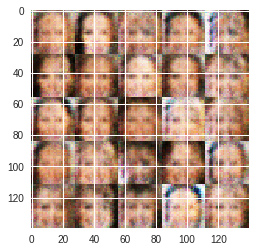

Epoch 1/2... Batches 21120/202599... Discriminator Loss: 0.6974... Generator Loss: 1.4411 Time_mins: 1
Epoch 1/2... Batches 23040/202599... Discriminator Loss: 0.9135... Generator Loss: 1.1361 Time_mins: 1
Epoch 1/2... Batches 24960/202599... Discriminator Loss: 0.9688... Generator Loss: 1.7730 Time_mins: 1
Epoch 1/2... Batches 26880/202599... Discriminator Loss: 1.1817... Generator Loss: 0.9849 Time_mins: 1
Epoch 1/2... Batches 28800/202599... Discriminator Loss: 1.0530... Generator Loss: 1.4908 Time_mins: 1
Epoch 1/2... Batches 30720/202599... Discriminator Loss: 1.6549... Generator Loss: 0.3357 Time_mins: 1
Epoch 1/2... Batches 32640/202599... Discriminator Loss: 0.9711... Generator Loss: 0.9670 Time_mins: 2
Epoch 1/2... Batches 34560/202599... Discriminator Loss: 1.0396... Generator Loss: 1.0047 Time_mins: 2
Epoch 1/2... Batches 36480/202599... Discriminator Loss: 0.9913... Generator Loss: 0.8163 Time_mins: 2
Epoch 1/2... Batches 38400/202599... Discriminator Loss: 1.0513... Genera

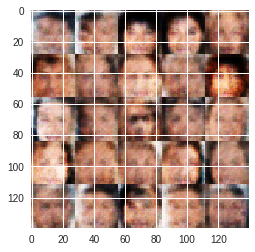

Epoch 1/2... Batches 40320/202599... Discriminator Loss: 0.9821... Generator Loss: 1.5147 Time_mins: 2
Epoch 1/2... Batches 42240/202599... Discriminator Loss: 0.9846... Generator Loss: 0.9431 Time_mins: 2
Epoch 1/2... Batches 44160/202599... Discriminator Loss: 1.1605... Generator Loss: 0.5655 Time_mins: 2
Epoch 1/2... Batches 46080/202599... Discriminator Loss: 1.2220... Generator Loss: 0.5740 Time_mins: 2
Epoch 1/2... Batches 48000/202599... Discriminator Loss: 1.0876... Generator Loss: 0.8042 Time_mins: 2
Epoch 1/2... Batches 49920/202599... Discriminator Loss: 1.1202... Generator Loss: 1.0557 Time_mins: 2
Epoch 1/2... Batches 51840/202599... Discriminator Loss: 1.3922... Generator Loss: 1.1050 Time_mins: 2
Epoch 1/2... Batches 53760/202599... Discriminator Loss: 0.9249... Generator Loss: 1.6124 Time_mins: 2
Epoch 1/2... Batches 55680/202599... Discriminator Loss: 1.1026... Generator Loss: 0.5938 Time_mins: 3
Epoch 1/2... Batches 57600/202599... Discriminator Loss: 1.1966... Genera

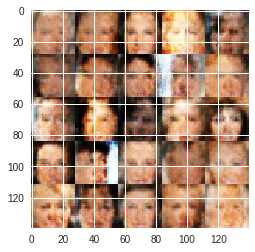

Epoch 1/2... Batches 59520/202599... Discriminator Loss: 0.7893... Generator Loss: 1.3582 Time_mins: 3
Epoch 1/2... Batches 61440/202599... Discriminator Loss: 0.8201... Generator Loss: 1.2112 Time_mins: 3
Epoch 1/2... Batches 63360/202599... Discriminator Loss: 1.1974... Generator Loss: 0.5553 Time_mins: 3
Epoch 1/2... Batches 65280/202599... Discriminator Loss: 1.1595... Generator Loss: 0.7964 Time_mins: 3
Epoch 1/2... Batches 67200/202599... Discriminator Loss: 1.1439... Generator Loss: 1.5518 Time_mins: 3
Epoch 1/2... Batches 69120/202599... Discriminator Loss: 0.8772... Generator Loss: 1.8876 Time_mins: 3
Epoch 1/2... Batches 71040/202599... Discriminator Loss: 1.6906... Generator Loss: 0.2638 Time_mins: 3
Epoch 1/2... Batches 72960/202599... Discriminator Loss: 1.3207... Generator Loss: 0.4443 Time_mins: 3
Epoch 1/2... Batches 74880/202599... Discriminator Loss: 1.4280... Generator Loss: 0.3570 Time_mins: 3
Epoch 1/2... Batches 76800/202599... Discriminator Loss: 0.8560... Genera

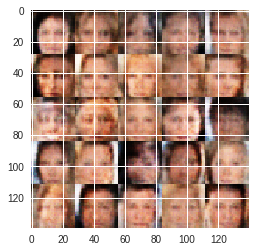

Epoch 1/2... Batches 78720/202599... Discriminator Loss: 0.7392... Generator Loss: 1.1057 Time_mins: 4
Epoch 1/2... Batches 80640/202599... Discriminator Loss: 1.1669... Generator Loss: 0.6340 Time_mins: 4
Epoch 1/2... Batches 82560/202599... Discriminator Loss: 1.0658... Generator Loss: 0.6730 Time_mins: 4
Epoch 1/2... Batches 84480/202599... Discriminator Loss: 1.4266... Generator Loss: 0.3894 Time_mins: 4
Epoch 1/2... Batches 86400/202599... Discriminator Loss: 1.0108... Generator Loss: 1.0043 Time_mins: 4
Epoch 1/2... Batches 88320/202599... Discriminator Loss: 1.0285... Generator Loss: 1.4085 Time_mins: 4
Epoch 1/2... Batches 90240/202599... Discriminator Loss: 1.0392... Generator Loss: 0.6768 Time_mins: 4
Epoch 1/2... Batches 92160/202599... Discriminator Loss: 0.8614... Generator Loss: 1.0344 Time_mins: 4
Epoch 1/2... Batches 94080/202599... Discriminator Loss: 1.1258... Generator Loss: 0.7836 Time_mins: 4
Epoch 1/2... Batches 96000/202599... Discriminator Loss: 0.8956... Genera

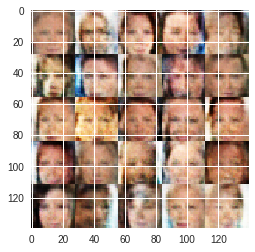

Epoch 1/2... Batches 97920/202599... Discriminator Loss: 1.0640... Generator Loss: 1.2692 Time_mins: 4
Epoch 1/2... Batches 99840/202599... Discriminator Loss: 1.1406... Generator Loss: 1.5211 Time_mins: 4
Epoch 1/2... Batches 101760/202599... Discriminator Loss: 1.1418... Generator Loss: 0.9496 Time_mins: 5
Epoch 1/2... Batches 103680/202599... Discriminator Loss: 0.4753... Generator Loss: 1.3976 Time_mins: 5
Epoch 1/2... Batches 105600/202599... Discriminator Loss: 0.7093... Generator Loss: 1.3248 Time_mins: 5
Epoch 1/2... Batches 107520/202599... Discriminator Loss: 1.2010... Generator Loss: 0.5072 Time_mins: 5
Epoch 1/2... Batches 109440/202599... Discriminator Loss: 0.8037... Generator Loss: 1.4497 Time_mins: 5
Epoch 1/2... Batches 111360/202599... Discriminator Loss: 1.1104... Generator Loss: 0.8937 Time_mins: 5
Epoch 1/2... Batches 113280/202599... Discriminator Loss: 0.9643... Generator Loss: 0.7398 Time_mins: 5
Epoch 1/2... Batches 115200/202599... Discriminator Loss: 0.6669..

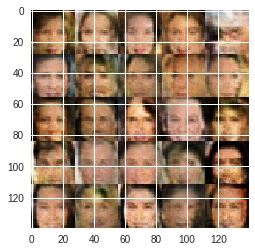

Epoch 1/2... Batches 117120/202599... Discriminator Loss: 1.6825... Generator Loss: 0.2865 Time_mins: 5
Epoch 1/2... Batches 119040/202599... Discriminator Loss: 0.9029... Generator Loss: 0.9371 Time_mins: 5
Epoch 1/2... Batches 120960/202599... Discriminator Loss: 1.3508... Generator Loss: 0.4689 Time_mins: 5
Epoch 1/2... Batches 122880/202599... Discriminator Loss: 1.0265... Generator Loss: 0.7084 Time_mins: 5
Epoch 1/2... Batches 124800/202599... Discriminator Loss: 1.2262... Generator Loss: 0.4520 Time_mins: 6
Epoch 1/2... Batches 126720/202599... Discriminator Loss: 1.2695... Generator Loss: 0.4232 Time_mins: 6
Epoch 1/2... Batches 128640/202599... Discriminator Loss: 1.8280... Generator Loss: 0.2088 Time_mins: 6
Epoch 1/2... Batches 130560/202599... Discriminator Loss: 1.2410... Generator Loss: 1.4708 Time_mins: 6
Epoch 1/2... Batches 132480/202599... Discriminator Loss: 1.0579... Generator Loss: 0.6382 Time_mins: 6
Epoch 1/2... Batches 134400/202599... Discriminator Loss: 0.6876

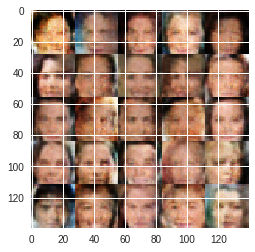

Epoch 1/2... Batches 136320/202599... Discriminator Loss: 1.2958... Generator Loss: 0.4377 Time_mins: 6
Epoch 1/2... Batches 138240/202599... Discriminator Loss: 0.6593... Generator Loss: 1.2259 Time_mins: 6
Epoch 1/2... Batches 140160/202599... Discriminator Loss: 2.0233... Generator Loss: 0.1651 Time_mins: 6
Epoch 1/2... Batches 142080/202599... Discriminator Loss: 1.3199... Generator Loss: 0.4049 Time_mins: 6
Epoch 1/2... Batches 144000/202599... Discriminator Loss: 1.1113... Generator Loss: 0.9136 Time_mins: 6
Epoch 1/2... Batches 145920/202599... Discriminator Loss: 1.0948... Generator Loss: 0.6093 Time_mins: 7
Epoch 1/2... Batches 147840/202599... Discriminator Loss: 0.8226... Generator Loss: 1.1915 Time_mins: 7
Epoch 1/2... Batches 149760/202599... Discriminator Loss: 1.0799... Generator Loss: 1.0152 Time_mins: 7
Epoch 1/2... Batches 151680/202599... Discriminator Loss: 0.9313... Generator Loss: 1.0248 Time_mins: 7
Epoch 1/2... Batches 153600/202599... Discriminator Loss: 1.0647

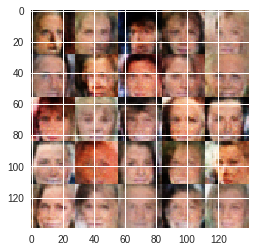

Epoch 1/2... Batches 155520/202599... Discriminator Loss: 1.3942... Generator Loss: 0.4007 Time_mins: 7
Epoch 1/2... Batches 157440/202599... Discriminator Loss: 1.4024... Generator Loss: 0.3558 Time_mins: 7
Epoch 1/2... Batches 159360/202599... Discriminator Loss: 1.0301... Generator Loss: 0.6369 Time_mins: 7
Epoch 1/2... Batches 161280/202599... Discriminator Loss: 1.5152... Generator Loss: 0.3888 Time_mins: 7
Epoch 1/2... Batches 163200/202599... Discriminator Loss: 1.3248... Generator Loss: 0.4042 Time_mins: 7
Epoch 1/2... Batches 165120/202599... Discriminator Loss: 1.8374... Generator Loss: 0.2132 Time_mins: 7
Epoch 1/2... Batches 167040/202599... Discriminator Loss: 0.9773... Generator Loss: 0.7933 Time_mins: 7
Epoch 1/2... Batches 168960/202599... Discriminator Loss: 1.3643... Generator Loss: 0.3921 Time_mins: 8
Epoch 1/2... Batches 170880/202599... Discriminator Loss: 0.8097... Generator Loss: 0.9169 Time_mins: 8
Epoch 1/2... Batches 172800/202599... Discriminator Loss: 0.9394

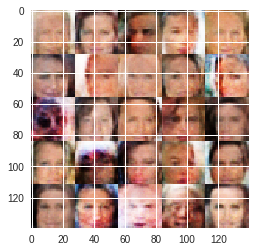

Epoch 1/2... Batches 174720/202599... Discriminator Loss: 0.8665... Generator Loss: 0.9938 Time_mins: 8
Epoch 1/2... Batches 176640/202599... Discriminator Loss: 0.4586... Generator Loss: 1.3972 Time_mins: 8
Epoch 1/2... Batches 178560/202599... Discriminator Loss: 1.1573... Generator Loss: 1.1949 Time_mins: 8
Epoch 1/2... Batches 180480/202599... Discriminator Loss: 1.4957... Generator Loss: 1.7414 Time_mins: 8
Epoch 1/2... Batches 182400/202599... Discriminator Loss: 1.1374... Generator Loss: 0.5802 Time_mins: 8
Epoch 1/2... Batches 184320/202599... Discriminator Loss: 1.1094... Generator Loss: 0.5529 Time_mins: 8
Epoch 1/2... Batches 186240/202599... Discriminator Loss: 1.2907... Generator Loss: 0.4435 Time_mins: 8
Epoch 1/2... Batches 188160/202599... Discriminator Loss: 0.8279... Generator Loss: 1.1859 Time_mins: 8
Epoch 1/2... Batches 190080/202599... Discriminator Loss: 0.8709... Generator Loss: 0.7263 Time_mins: 8
Epoch 1/2... Batches 192000/202599... Discriminator Loss: 0.7910

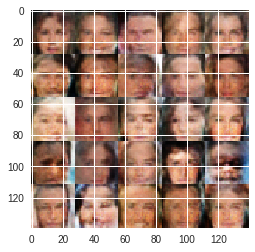

Epoch 1/2... Batches 193920/202599... Discriminator Loss: 0.8792... Generator Loss: 0.9766 Time_mins: 9
Epoch 1/2... Batches 195840/202599... Discriminator Loss: 0.9052... Generator Loss: 0.9029 Time_mins: 9
Epoch 1/2... Batches 197760/202599... Discriminator Loss: 1.1383... Generator Loss: 1.6471 Time_mins: 9
Epoch 1/2... Batches 199680/202599... Discriminator Loss: 1.1346... Generator Loss: 1.5762 Time_mins: 9
Epoch 1/2... Batches 201600/202599... Discriminator Loss: 0.4334... Generator Loss: 1.7199 Time_mins: 9
Epoch 2/2... Batches 101760/202599... Discriminator Loss: 1.3428... Generator Loss: 0.4323 Time_mins: 9
Epoch 2/2... Batches 102720/202599... Discriminator Loss: 1.1554... Generator Loss: 0.6015 Time_mins: 9
Epoch 2/2... Batches 103680/202599... Discriminator Loss: 0.9842... Generator Loss: 0.7847 Time_mins: 9
Epoch 2/2... Batches 104640/202599... Discriminator Loss: 0.9657... Generator Loss: 1.5011 Time_mins: 9
Epoch 2/2... Batches 105600/202599... Discriminator Loss: 0.8713

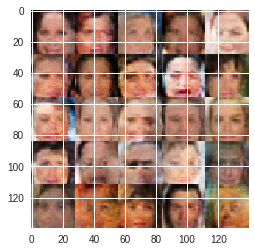

Epoch 2/2... Batches 106560/202599... Discriminator Loss: 0.8982... Generator Loss: 0.9313 Time_mins: 10
Epoch 2/2... Batches 107520/202599... Discriminator Loss: 0.9515... Generator Loss: 1.1530 Time_mins: 10
Epoch 2/2... Batches 108480/202599... Discriminator Loss: 0.8660... Generator Loss: 1.3517 Time_mins: 10
Epoch 2/2... Batches 109440/202599... Discriminator Loss: 1.2140... Generator Loss: 0.4393 Time_mins: 10
Epoch 2/2... Batches 110400/202599... Discriminator Loss: 1.4582... Generator Loss: 0.3459 Time_mins: 10
Epoch 2/2... Batches 111360/202599... Discriminator Loss: 0.9855... Generator Loss: 0.8231 Time_mins: 10
Epoch 2/2... Batches 112320/202599... Discriminator Loss: 1.3529... Generator Loss: 0.3874 Time_mins: 10
Epoch 2/2... Batches 113280/202599... Discriminator Loss: 0.7649... Generator Loss: 1.0915 Time_mins: 10
Epoch 2/2... Batches 114240/202599... Discriminator Loss: 1.2630... Generator Loss: 0.4408 Time_mins: 10
Epoch 2/2... Batches 115200/202599... Discriminator Los

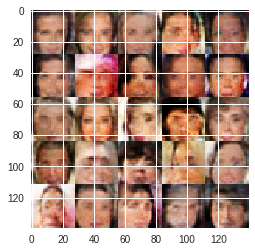

Epoch 2/2... Batches 116160/202599... Discriminator Loss: 0.7516... Generator Loss: 1.1707 Time_mins: 10
Epoch 2/2... Batches 117120/202599... Discriminator Loss: 0.9437... Generator Loss: 1.3095 Time_mins: 10
Epoch 2/2... Batches 118080/202599... Discriminator Loss: 1.1628... Generator Loss: 0.5599 Time_mins: 11
Epoch 2/2... Batches 119040/202599... Discriminator Loss: 1.1120... Generator Loss: 0.7629 Time_mins: 11
Epoch 2/2... Batches 120000/202599... Discriminator Loss: 1.5571... Generator Loss: 0.2988 Time_mins: 11
Epoch 2/2... Batches 120960/202599... Discriminator Loss: 0.9493... Generator Loss: 1.0259 Time_mins: 11
Epoch 2/2... Batches 121920/202599... Discriminator Loss: 1.5989... Generator Loss: 0.2821 Time_mins: 11
Epoch 2/2... Batches 122880/202599... Discriminator Loss: 1.0852... Generator Loss: 0.5263 Time_mins: 11
Epoch 2/2... Batches 123840/202599... Discriminator Loss: 0.7192... Generator Loss: 1.0012 Time_mins: 11
Epoch 2/2... Batches 124800/202599... Discriminator Los

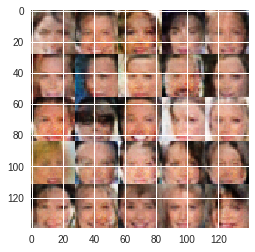

Epoch 2/2... Batches 125760/202599... Discriminator Loss: 0.7820... Generator Loss: 1.1745 Time_mins: 11
Epoch 2/2... Batches 126720/202599... Discriminator Loss: 1.2398... Generator Loss: 0.5346 Time_mins: 11
Epoch 2/2... Batches 127680/202599... Discriminator Loss: 0.8074... Generator Loss: 0.9038 Time_mins: 11
Epoch 2/2... Batches 128640/202599... Discriminator Loss: 1.8780... Generator Loss: 0.2155 Time_mins: 11
Epoch 2/2... Batches 129600/202599... Discriminator Loss: 1.1292... Generator Loss: 0.5804 Time_mins: 12
Epoch 2/2... Batches 130560/202599... Discriminator Loss: 0.9862... Generator Loss: 0.9425 Time_mins: 12
Epoch 2/2... Batches 131520/202599... Discriminator Loss: 1.5474... Generator Loss: 0.3141 Time_mins: 12
Epoch 2/2... Batches 132480/202599... Discriminator Loss: 1.1636... Generator Loss: 0.5779 Time_mins: 12
Epoch 2/2... Batches 133440/202599... Discriminator Loss: 1.1315... Generator Loss: 0.6167 Time_mins: 12
Epoch 2/2... Batches 134400/202599... Discriminator Los

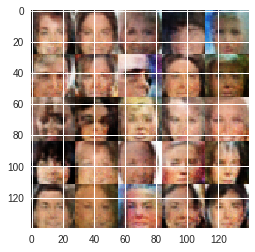

Epoch 2/2... Batches 135360/202599... Discriminator Loss: 1.2394... Generator Loss: 0.4826 Time_mins: 12
Epoch 2/2... Batches 136320/202599... Discriminator Loss: 0.8245... Generator Loss: 0.8813 Time_mins: 12
Epoch 2/2... Batches 137280/202599... Discriminator Loss: 1.1152... Generator Loss: 0.9704 Time_mins: 12
Epoch 2/2... Batches 138240/202599... Discriminator Loss: 0.8097... Generator Loss: 0.9988 Time_mins: 12
Epoch 2/2... Batches 139200/202599... Discriminator Loss: 0.9399... Generator Loss: 0.8445 Time_mins: 12
Epoch 2/2... Batches 140160/202599... Discriminator Loss: 0.6684... Generator Loss: 1.9851 Time_mins: 13
Epoch 2/2... Batches 141120/202599... Discriminator Loss: 0.8513... Generator Loss: 1.7028 Time_mins: 13
Epoch 2/2... Batches 142080/202599... Discriminator Loss: 1.2233... Generator Loss: 0.6115 Time_mins: 13
Epoch 2/2... Batches 143040/202599... Discriminator Loss: 0.8774... Generator Loss: 0.8975 Time_mins: 13
Epoch 2/2... Batches 144000/202599... Discriminator Los

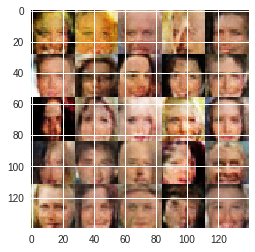

Epoch 2/2... Batches 144960/202599... Discriminator Loss: 1.5137... Generator Loss: 0.2992 Time_mins: 13
Epoch 2/2... Batches 145920/202599... Discriminator Loss: 0.7729... Generator Loss: 1.1723 Time_mins: 13
Epoch 2/2... Batches 146880/202599... Discriminator Loss: 0.8500... Generator Loss: 0.9119 Time_mins: 13
Epoch 2/2... Batches 147840/202599... Discriminator Loss: 1.3148... Generator Loss: 0.4835 Time_mins: 13
Epoch 2/2... Batches 148800/202599... Discriminator Loss: 1.0339... Generator Loss: 0.6895 Time_mins: 13
Epoch 2/2... Batches 149760/202599... Discriminator Loss: 0.8502... Generator Loss: 1.2417 Time_mins: 13
Epoch 2/2... Batches 150720/202599... Discriminator Loss: 0.8086... Generator Loss: 1.3354 Time_mins: 13
Epoch 2/2... Batches 151680/202599... Discriminator Loss: 1.0350... Generator Loss: 0.6591 Time_mins: 14
Epoch 2/2... Batches 152640/202599... Discriminator Loss: 0.9256... Generator Loss: 1.1176 Time_mins: 14
Epoch 2/2... Batches 153600/202599... Discriminator Los

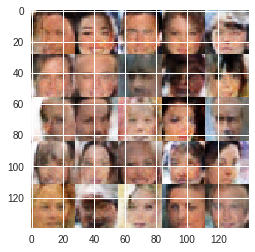

Epoch 2/2... Batches 154560/202599... Discriminator Loss: 0.8821... Generator Loss: 1.0463 Time_mins: 14
Epoch 2/2... Batches 155520/202599... Discriminator Loss: 1.2911... Generator Loss: 0.3749 Time_mins: 14
Epoch 2/2... Batches 156480/202599... Discriminator Loss: 1.4891... Generator Loss: 0.3644 Time_mins: 14
Epoch 2/2... Batches 157440/202599... Discriminator Loss: 1.3253... Generator Loss: 0.3922 Time_mins: 14
Epoch 2/2... Batches 158400/202599... Discriminator Loss: 0.6760... Generator Loss: 1.0609 Time_mins: 14
Epoch 2/2... Batches 159360/202599... Discriminator Loss: 1.4909... Generator Loss: 0.3335 Time_mins: 14
Epoch 2/2... Batches 160320/202599... Discriminator Loss: 1.0196... Generator Loss: 0.8603 Time_mins: 14
Epoch 2/2... Batches 161280/202599... Discriminator Loss: 1.0500... Generator Loss: 0.5744 Time_mins: 14
Epoch 2/2... Batches 162240/202599... Discriminator Loss: 0.9872... Generator Loss: 0.6657 Time_mins: 15
Epoch 2/2... Batches 163200/202599... Discriminator Los

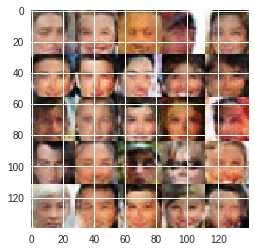

Epoch 2/2... Batches 164160/202599... Discriminator Loss: 0.8804... Generator Loss: 0.9962 Time_mins: 15
Epoch 2/2... Batches 165120/202599... Discriminator Loss: 1.0977... Generator Loss: 1.1692 Time_mins: 15
Epoch 2/2... Batches 166080/202599... Discriminator Loss: 0.9131... Generator Loss: 0.6385 Time_mins: 15
Epoch 2/2... Batches 167040/202599... Discriminator Loss: 0.8081... Generator Loss: 1.0550 Time_mins: 15
Epoch 2/2... Batches 168000/202599... Discriminator Loss: 0.6461... Generator Loss: 1.3429 Time_mins: 15
Epoch 2/2... Batches 168960/202599... Discriminator Loss: 0.9070... Generator Loss: 0.9554 Time_mins: 15
Epoch 2/2... Batches 169920/202599... Discriminator Loss: 1.2718... Generator Loss: 0.8093 Time_mins: 15
Epoch 2/2... Batches 170880/202599... Discriminator Loss: 1.4480... Generator Loss: 0.3383 Time_mins: 15
Epoch 2/2... Batches 171840/202599... Discriminator Loss: 1.1144... Generator Loss: 0.6660 Time_mins: 15
Epoch 2/2... Batches 172800/202599... Discriminator Los

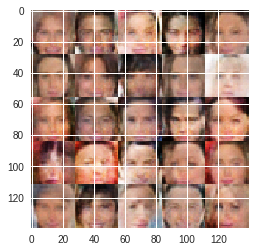

Epoch 2/2... Batches 173760/202599... Discriminator Loss: 1.0334... Generator Loss: 0.6622 Time_mins: 16
Epoch 2/2... Batches 174720/202599... Discriminator Loss: 0.8295... Generator Loss: 1.6358 Time_mins: 16
Epoch 2/2... Batches 175680/202599... Discriminator Loss: 1.5797... Generator Loss: 0.2717 Time_mins: 16
Epoch 2/2... Batches 176640/202599... Discriminator Loss: 1.1117... Generator Loss: 0.5343 Time_mins: 16
Epoch 2/2... Batches 177600/202599... Discriminator Loss: 0.8863... Generator Loss: 0.8298 Time_mins: 16
Epoch 2/2... Batches 178560/202599... Discriminator Loss: 0.8932... Generator Loss: 1.0132 Time_mins: 16
Epoch 2/2... Batches 179520/202599... Discriminator Loss: 0.8271... Generator Loss: 0.9321 Time_mins: 16
Epoch 2/2... Batches 180480/202599... Discriminator Loss: 1.0152... Generator Loss: 0.9945 Time_mins: 16
Epoch 2/2... Batches 181440/202599... Discriminator Loss: 0.9247... Generator Loss: 0.9659 Time_mins: 16
Epoch 2/2... Batches 182400/202599... Discriminator Los

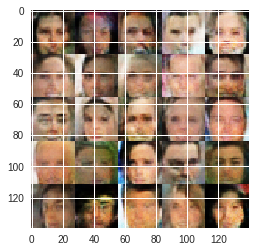

Epoch 2/2... Batches 183360/202599... Discriminator Loss: 1.0380... Generator Loss: 0.6458 Time_mins: 16
Epoch 2/2... Batches 184320/202599... Discriminator Loss: 1.0738... Generator Loss: 0.5493 Time_mins: 16
Epoch 2/2... Batches 185280/202599... Discriminator Loss: 0.6384... Generator Loss: 1.2666 Time_mins: 17
Epoch 2/2... Batches 186240/202599... Discriminator Loss: 1.0072... Generator Loss: 0.7498 Time_mins: 17
Epoch 2/2... Batches 187200/202599... Discriminator Loss: 0.8519... Generator Loss: 1.0985 Time_mins: 17
Epoch 2/2... Batches 188160/202599... Discriminator Loss: 0.9153... Generator Loss: 0.8477 Time_mins: 17
Epoch 2/2... Batches 189120/202599... Discriminator Loss: 1.3871... Generator Loss: 0.3760 Time_mins: 17
Epoch 2/2... Batches 190080/202599... Discriminator Loss: 0.9969... Generator Loss: 0.6467 Time_mins: 17
Epoch 2/2... Batches 191040/202599... Discriminator Loss: 1.2520... Generator Loss: 0.7543 Time_mins: 17
Epoch 2/2... Batches 192000/202599... Discriminator Los

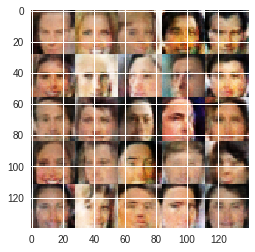

Epoch 2/2... Batches 192960/202599... Discriminator Loss: 1.1776... Generator Loss: 0.9203 Time_mins: 17
Epoch 2/2... Batches 193920/202599... Discriminator Loss: 0.5207... Generator Loss: 1.4809 Time_mins: 17
Epoch 2/2... Batches 194880/202599... Discriminator Loss: 0.8918... Generator Loss: 1.5064 Time_mins: 17
Epoch 2/2... Batches 195840/202599... Discriminator Loss: 1.1642... Generator Loss: 0.6109 Time_mins: 18
Epoch 2/2... Batches 196800/202599... Discriminator Loss: 1.4944... Generator Loss: 0.3352 Time_mins: 18
Epoch 2/2... Batches 197760/202599... Discriminator Loss: 0.7560... Generator Loss: 2.0054 Time_mins: 18
Epoch 2/2... Batches 198720/202599... Discriminator Loss: 1.4310... Generator Loss: 0.5108 Time_mins: 18
Epoch 2/2... Batches 199680/202599... Discriminator Loss: 0.6694... Generator Loss: 1.4475 Time_mins: 18
Epoch 2/2... Batches 200640/202599... Discriminator Loss: 1.2611... Generator Loss: 0.4959 Time_mins: 18
Epoch 2/2... Batches 201600/202599... Discriminator Los

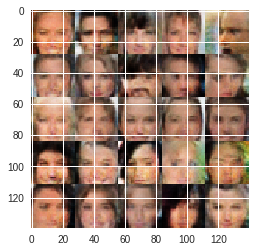

Epoch 2/2... Batches 202560/202599... Discriminator Loss: 0.7477... Generator Loss: 1.1064 Time_mins: 18


In [81]:
batch_size = 32
z_dim = 100
learning_rate = 0.00015
beta1 = 0.35
tf.reset_default_graph

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.